# SRH03 Sensitivity and Hodograph Panel-Plot Code for WoFS

##### Supplementary code for Faletti et al. (2026): _Using Ensemble Sensitivity to Diagnose Environmental Modulation of Mesocyclone Intensity in the Warn-on-Forecast System_

### Reproduces Fig. 19

In [1]:
#######################################################################################
#                                                                                     #
#        Plots area-averaged hodographs within a defined near-inflow region.          #
#                                                                                     #
#######################################################################################

import xarray as xr
import numpy as np
import datetime
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import SkewT

#import wofs_cbook_mod_part2 as wcalc
import centered_response as cr
from wofunits import wofunits

import warnings
warnings.filterwarnings("ignore")

## Manually set time, inflow domain specs, etc. for the desired plotting

In [2]:
################################ Set case/plotting specs  #######################################

    # save scatter plots?
save = False

    # select case
cases = ['201905172200','201905202030','201905262000','201905282230']*2

    # select time and variables
lead_time = 30 # lead time in minutes
statevar, respvar = 'SRH3-TRUE','UH25-30MIN'

    # domain thresholding specs
inflow_region = 'nf'
pthres = 0.05
pstat_sign = '+'
ang_thres = 180
nf_dist = 40 # distance bound of near-inflow domain
ff_dist = 120 # distance bound of far-inflow domain
ang_bound1, ang_bound2 = 40, 240 # angular domain bounds relative to the storm motion
domain_lag = 0 # distance lag of domain origin to storm center in km

    # define common directories for file paths
sensdir = wofunits.paths['sens_path'] # sensitivity file path
respdir_sr = wofunits.paths['resp_path'] # response function file path
wofsdir = wofunits.paths['wofs_path'] # WoFS data path
wofsdir_3d = wofunits.paths['wofs_path_3d'] # 3D WoFS data path
sm_path = wofunits.paths['sm_path'] # storm motion data path
outplot_path = wofunits.paths['outplot_path'] # figure save directory

axlabels = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

## Plot Fig. 19: SRH03 Sensitivity and Near-Inflow Mean Hodographs by Tercile

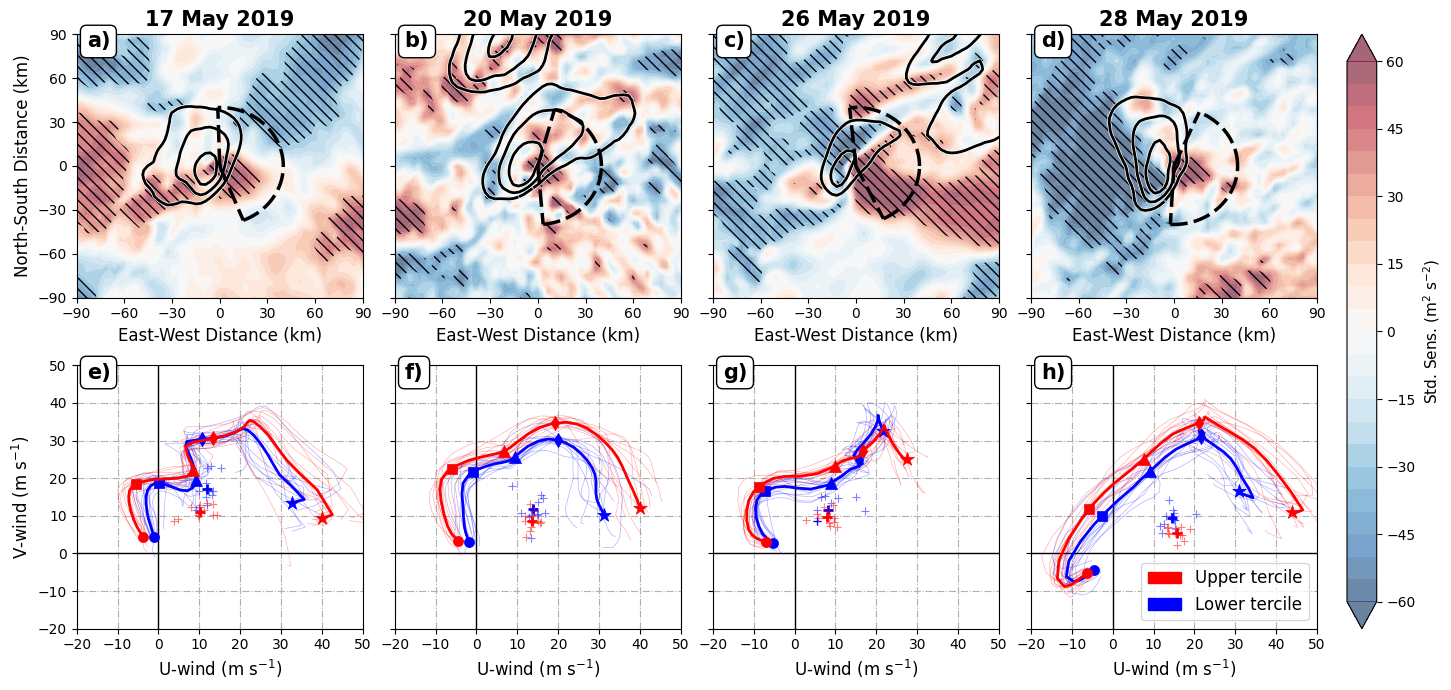

In [3]:
fig, ax = plt.subplots(2,4,figsize=(16,7))
ax = ax.flatten()

for i, case in enumerate(cases):
    
    ################################ Set case/plotting specs  #######################################
        
        # pull case specs
    wofs_casedir, file_latlons, file_coords, file_resp_coords, file_mrms_maxima, files_wofs, state_times, resptime = cr.case_sel(case)
    
    respvar_filestr = respvar.replace('-','_')
    
        # define state and response time as datetime objects
    resp_time = datetime.datetime.strptime(resptime, '%Y-%m-%d_%H_%M_%S')
    state_time = resp_time - datetime.timedelta(minutes=lead_time)
    
        # define file strings for given variables and time
    file_sens = f'{sensdir}/sens_center_{case}/stats_{respvar}_max_{str(resp_time.hour).zfill(2)}_{str(resp_time.minute).zfill(2)}_00_{statevar}_{str(state_time.hour).zfill(2)}_{str(state_time.minute).zfill(2)}_00.nc'
    file_resp_sr = f'{respdir_sr}/resp_{respvar_filestr}_max_{resptime}.nc'
    file_ref = f'{wofsdir}/wofs_{case[:8]}_{case[8:]}/wofs_center_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
    file_3d = f'{wofsdir_3d}/wofs_{case[:8]}_{case[8:]}/wofs_3dcenter_i{case}_v{state_time.year}{str(state_time.month).zfill(2)}{str(state_time.day).zfill(2)}{str(state_time.hour).zfill(2)}{str(state_time.minute).zfill(2)}.nc'
    
        # open netCDF files
    ds_sens = xr.open_dataset(file_sens)
    ds_ref = xr.open_dataset(file_ref)
    ds_3d = xr.open_dataset(file_3d)
    ds_resp_sr = xr.open_dataset(file_resp_sr)
    
        # define variables for overview plots
    sens = ds_sens.stdsens
    cref = np.where(np.nanmean(ds_ref.REFD_MAX, axis=0) < 10, np.nan, np.nanmean(ds_ref.REFD_MAX, axis=0))[0]
    pstat = ds_sens.pstat.values
    
        # define response variables
    uhresp_sr = ds_resp_sr[respvar_filestr]
        
        # define PBL scheme indices
    ysu_idx, myj_idx, mynn_idx = wofunits.schemeidx['ysu'], wofunits.schemeidx['myj'], wofunits.schemeidx['mynn']

        # define tercile indices
    upp_terc = wofunits.rankidx[case][respvar][:12]
    low_terc = wofunits.rankidx[case][respvar][24:]
    
    ################################ Define storm-relative aspects  #######################################
    
        # define observed MRMS storm centers to center storm on plot
    df_center = cr.create_mrmscenter_df(file_coords, file_mrms_maxima)
    
        # string to 
    pdstr = f'{state_time.year}-{str(state_time.month).zfill(2)}-{str(state_time.day).zfill(2)} {str(state_time.hour).zfill(2)}:{str(state_time.minute).zfill(2)}:00'
    
        # open storm motion csv files
    sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
    sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')
    
        # average storm motion components at chosen time
    sm_mean_x = np.nanmean(sm_x[:-1][pdstr].values)
    sm_mean_y = np.nanmean(sm_y[:-1][pdstr].values)
    
        # calculate angle of storm motion relative to positive x-axis
    storm_ang = cr.calc_storm_ang(sm_mean_x, sm_mean_y)
    
        # create 2D x and y storm-relative grids
    xmesh,ymesh = cr.xy_mesh(case, state_time)
    dist = (xmesh**2 + ymesh**2)**0.5 # convert to 2D meshgrid
    
        # calculate storm-relative angle of each gridpoint 
    ang_tot = cr.calc_ang_tot(xmesh,ymesh,storm_ang=storm_ang)
    
        # calculate angle difference between SR gridpoint position and SR 
    ang_diff = cr.srw_ang_diff(case, state_time)
    
    ################################ Begin data processing  #######################################
    
    if i < 4:
        cb = ax[i].contourf(xmesh, ymesh, sens, cmap='RdBu_r', levels=np.arange(-60,61,5), extend='both',
                               antialiased=True, alpha=0.6)

        ax[i].contour(xmesh, ymesh, cref, levels=[20,35,50], colors='w', linewidths=3)
        ax[i].contour(xmesh, ymesh, cref, levels=[20,35,50], colors='k', linewidths=2)
        
        ax[i].contourf(xmesh, ymesh, abs(pstat), [0, 0.1], colors='none', hatches=['\\\\\\'], extend='lower')
        
        cr.plot_domain(storm_ang = storm_ang, 
                    ang_bounds = (ang_bound1, ang_bound2), 
                       if_region='nf', lw=2.5, color='k',
                       subplot=True, ax=ax[i])
        
        ax[i].set_xticks(np.arange(-90,91,30))
        ax[i].set_yticks(np.arange(-90,91,30))
        
        #cbar = ax.colorbar(cb, label=wofunits.labels['UH-30SWT25'])
        #cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=8)
        
        if i == 0:
            ax[i].set_ylabel('North-South Distance (km)', size=12)
        else:
            ax[i].set_ylabel('', size=12)
            ax[i].set_yticklabels([])
        
        ax[i].set_xlabel('East-West Distance (km)', size=12)
        
        ax[i].set_xlim(-90,90)
        ax[i].set_ylim(-90,90)
        
        #validtime = pdstr[:16].replace(':','')
        ax[i].set_title(f'{case[6:8]} May 2019', size=15, weight='bold')
    
        # axis labels
        ax[i].text(0.035, 0.95, axlabels[i], color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=15, weight='bold')
        
    elif i >= 4:
            # define 3D state variables
        u = ds_3d.U[:,0].values
        v = ds_3d.V[:,0].values
        z = ds_3d.Z_AGL[:,0].values
        p = ds_3d.P[:,0].values/100
        dz = ds_3d.DZ[:,0].values
    
    
            # define 3D thresholding variables 
        dist_3d = np.stack([np.stack([dist]*50)]*36)
        ang_tot_3d = np.stack([np.stack([ang_tot]*50)]*36)
        ang_diff_3d = np.stack([np.stack([ang_diff]*50)]*36)
        pstat_3d_ = np.stack([np.stack([pstat]*50)]*36)
        
            # account for +/- sensitivity through pstat
        if pstat_sign == '+':
            pstat_3d = abs(np.where(pstat_3d_ <= 0, np.nan, pstat_3d_))
            #pstat_3d = np.where(pstat_3d > pthres, np.nan, pstat_3d)
        elif pstat_sign == '-':
            pstat_3d = abs(np.where(pstat_3d_ > 0, np.nan, pstat_3d_))
        elif pstat_sign == 'all':
            pstat_3d = abs(pstat_3d_)
        
            # perform thresholding and process mean profiles
        if inflow_region == 'ff':
            u_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
            v_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
            z_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
            p_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
            dz_thres = np.nanmean(np.where( (dist_3d < nf_dist) | (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))
        elif inflow_region == 'nf':
            u_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
            v_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
            z_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
            p_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
            dz_thres = np.nanmean(np.where( (dist_3d > nf_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))
        elif inflow_region == 'if':
            u_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, u), axis=(2,3))
            v_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, v), axis=(2,3))
            z_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, z), axis=(2,3))
            p_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, p), axis=(2,3))
            dz_thres = np.nanmean(np.where( (dist_3d > ff_dist) | (ang_tot_3d > ang_bound1) & (ang_tot_3d < ang_bound2) | (ang_diff_3d > ang_thres) | (pstat_3d > pthres) | np.isnan(pstat_3d), np.nan, dz), axis=(2,3))   
        
        u_upp = u_thres[upp_terc,:]
        v_upp = v_thres[upp_terc,:]
        z_upp = z_thres[upp_terc,:]
        p_upp = p_thres[upp_terc,:]
        dz_upp = dz_thres[upp_terc,:]
                  
        u_low = u_thres[low_terc,:]
        v_low = v_thres[low_terc,:]
        z_low = z_thres[low_terc,:]
        p_low = p_thres[low_terc,:]
        dz_low = dz_thres[low_terc,:]
        
        u_upp_mean = np.nanmean(u_upp, axis=0)
        v_upp_mean = np.nanmean(v_upp, axis=0)
        z_upp_mean = np.nanmean(z_upp, axis=0)
        p_upp_mean = np.nanmean(p_upp, axis=0)
        
        u_low_mean = np.nanmean(u_low, axis=0)
        v_low_mean = np.nanmean(v_low, axis=0)
        z_low_mean = np.nanmean(z_low, axis=0)
        p_low_mean = np.nanmean(p_low, axis=0)
        
        
        ulowpt_1km = np.interp(1000, z_low_mean, u_low_mean)
        ulowpt_3km = np.interp(3000, z_low_mean, u_low_mean)
        ulowpt_6km = np.interp(6000, z_low_mean, u_low_mean)
        ulowpt_12km = np.interp(12000, z_low_mean, u_low_mean)
        vlowpt_1km = np.interp(1000, z_low_mean, v_low_mean)
        vlowpt_3km = np.interp(3000, z_low_mean, v_low_mean)
        vlowpt_6km = np.interp(6000, z_low_mean, v_low_mean)
        vlowpt_12km = np.interp(12000, z_low_mean, v_low_mean)
        
        uupppt_1km = np.interp(1000, z_upp_mean, u_upp_mean)
        uupppt_3km = np.interp(3000, z_upp_mean, u_upp_mean)
        uupppt_6km = np.interp(6000, z_upp_mean, u_upp_mean)
        uupppt_12km = np.interp(12000, z_upp_mean, u_upp_mean)
        vupppt_1km = np.interp(1000, z_upp_mean, v_upp_mean)
        vupppt_3km = np.interp(3000, z_upp_mean, v_upp_mean)
        vupppt_6km = np.interp(6000, z_upp_mean, v_upp_mean)
        vupppt_12km = np.interp(12000, z_upp_mean, v_upp_mean)
        
        upppts = [u_upp_mean[0], v_upp_mean[0], uupppt_1km, vupppt_1km, uupppt_3km, vupppt_3km, uupppt_6km, vupppt_6km, uupppt_12km, vupppt_12km]
        lowpts = [u_low_mean[0], v_low_mean[0], ulowpt_1km, vlowpt_1km, ulowpt_3km, vlowpt_3km, ulowpt_6km, vlowpt_6km, ulowpt_12km, vlowpt_12km]
        
        z_, u_upp_12km, v_upp_12km = mpcalc.get_layer_heights(z_upp_mean*units.meter,
                                                 12000*units.meter,
                                                 u_upp_mean*units.meter_per_second,
                                                 v_upp_mean*units.meter_per_second)
        
        z_, u_low_12km, v_low_12km = mpcalc.get_layer_heights(z_low_mean*units.meter,
                                                 12000*units.meter,
                                                 u_low_mean*units.meter_per_second,
                                                 v_low_mean*units.meter_per_second)
        
        u_upps_12km = []
        v_upps_12km = []
        for j in range(len(p_upp)):
            z_, uvar, vvar = mpcalc.get_layer_heights(z_upp[j]*units.meter,
                                                 12000*units.meter,
                                                 u_upp[j]*units.meter_per_second,
                                                 v_upp[j]*units.meter_per_second)
            u_upps_12km.append(uvar)
            v_upps_12km.append(vvar)
            
        u_lows_12km = []
        v_lows_12km = []
        for j in range(len(p_low)):
            z_, uvar, vvar = mpcalc.get_layer_heights(z_low[j]*units.meter,
                                                 12000*units.meter,
                                                 u_low[j]*units.meter_per_second,
                                                 v_low[j]*units.meter_per_second)
            u_lows_12km.append(uvar)
            v_lows_12km.append(vvar)
        
        
            
        # Open and process observed storm motions
    
        sm_x = pd.read_csv(f'{sm_path}/{case}_motions_nx.csv', index_col='Member')
        sm_y = pd.read_csv(f'{sm_path}/{case}_motions_ny.csv', index_col='Member')
        
        sm_x_upp = sm_x[:-1][pdstr][upp_terc].values
        sm_y_upp = sm_y[:-1][pdstr][upp_terc].values
        sm_x_low = sm_x[:-1][pdstr][low_terc].values
        sm_y_low = sm_y[:-1][pdstr][low_terc].values
        
        sm_x_upp_mean = np.nanmean(sm_x_upp)
        sm_y_upp_mean = np.nanmean(sm_y_upp)
        
        sm_x_low_mean = np.nanmean(sm_x_low)
        sm_y_low_mean = np.nanmean(sm_y_low)
    
        
        ################################## Plotting ########################################
    
        for u_, v_ in zip(u_upps_12km, v_upps_12km):
            ax[i].plot(u_,v_, lw=0.5, alpha=0.3, c='r', zorder=94, label='_nolegend_')
        for u_, v_ in zip(u_lows_12km, v_lows_12km):
            ax[i].plot(u_,v_, lw=0.5, alpha=0.3, c='b', zorder=95, label='_nolegend_')
            
        ax[i].plot(u_upp_12km, v_upp_12km, lw=2, c='r', zorder=98, label='Upper Tercile')
        ax[i].plot(u_low_12km, v_low_12km, lw=2, c='b', zorder=96, label='Lower Tercile')
        
        markers = ['o', 's', '^', 'd', '*']
        sizes = [35*1.5,35*1.5,50*1.5,35*1.5,70*1.5]
        hgts = [0, 1, 3, 6, 12]
        for j in range(int(len(upppts)/2)):
            ax[i].scatter(upppts[2*j], upppts[2*j+1], color='r', lw=0.5, marker=markers[j], s=sizes[j], zorder=99)
            ax[i].scatter(lowpts[2*j], lowpts[2*j+1], color='b', lw=0.5, marker=markers[j], s=sizes[j], zorder=97)
            #ax[i].annotate(hgts[j], (upppts[2*j], upppts[2*j+1]-0.05), c='r', ha='center', va='center', fontsize=8, zorder=100)
            #ax[i].annotate(hgts[j], (lowpts[2*j], lowpts[2*j+1]-0.05), c='b', ha='center', va='center', fontsize=8, zorder=101)
            
        ax[i].scatter(sm_x_upp, sm_y_upp, s=30, marker='+', c='r', lw=0.8, alpha=0.5, zorder=112)
        ax[i].scatter(sm_x_upp_mean, sm_y_upp_mean, s=60, marker='+', c='r', lw=2, zorder=113)
        
        ax[i].scatter(sm_x_low, sm_y_low, s=30, marker='+', c='b', lw=0.8, alpha=0.5, zorder=110)
        ax[i].scatter(sm_x_low_mean, sm_y_low_mean, s=60, marker='+', c='b', lw=2, zorder=111)
        
        ax[i].set_xlabel('U-wind (m s$^{-1}$)', size=12)
        ax[i].set_xticks(np.arange(-20,51,10))
        
        if i > 4:
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
        else:
            ax[i].set_ylabel('V-wind (m s$^{-1}$)', size=12)
            
        #if i == 4:
        #    ax[i].legend()        
        
        ax[i].grid(ls='-.', zorder=0)
        ax[i].axhline(y=0, c='k', lw=1, zorder=2)
        ax[i].axvline(x=0, c='k', lw=1, zorder=3)
        
        ax[i].set_xlim(-20,50)
        ax[i].set_ylim(-20,50)
    
        # axis labels
        ax[i].text(0.035, 0.95, axlabels[i], color='k',
            bbox=dict(facecolor='w', boxstyle='round', edgecolor='k'), transform=ax[i].transAxes, 
            size=15, weight='bold')
    

red_patch = mpatches.Patch(color='red', label='Upper tercile') 
blue_patch = mpatches.Patch(color='blue', label='Lower tercile')
ax[7].legend(handles=[red_patch,blue_patch], fontsize=12)     

fig.tight_layout()

    # colorbar
cbar = fig.colorbar(cb, ax=ax, pad=0.02)
cbar.set_label(label=f'Std. Sens. ({wofunits.labels[respvar]})', size=11)

if save:
    plt.savefig(fname=f'{outplot_path}/hodo_panels.png', dpi=300, bbox_inches='tight', facecolor='w')